2023-01-25 12:32:18.435603: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-25 12:32:18.552319: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-25 12:32:18.557422: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /storage/icds/RISE/sw8/julia-1.8.1/julia-1.8.1/lib:/storage/icds/RISE/sw8/anaconda/anaconda3/lib

(2000, 5) (2000,)


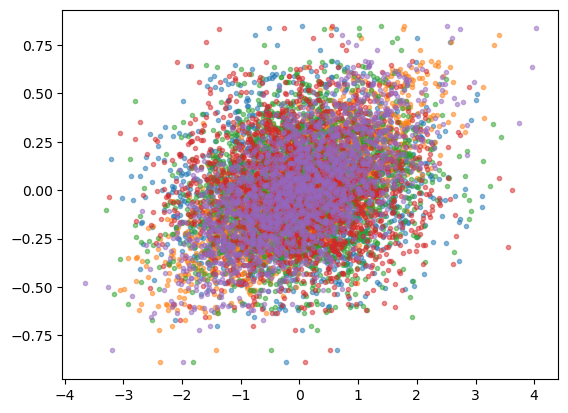

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import backend as K
import tensorflow as tf
tf.config.threading.set_inter_op_parallelism_threads(48)
from sklearn.model_selection import train_test_split
np.random.seed(0)
tf.keras.backend.set_floatx('float32')



# Number of features used to predict "RV"
n_feat = 5

# Make random signal
# X = your RV features, y = the real RVs, and t = time
X, y = make_regression(n_samples=2000, n_features=n_feat,
				random_state=1, noise=0.1)
y = y/500.0
t = np.sort(np.random.uniform(0,1,2000))
print(X.shape, y.shape)
import matplotlib.pyplot as plt
plt.plot(X, y, '.', alpha=0.5)
plt.show()

# Add sinusoidal to everything
y = y + 2.0 * np.sin(t*11+ 0.5)

X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(
    X, y,t, test_size=0.33, random_state=42)

In [2]:
# This custom layer has 2 inputs and 1 output
# First input = the RV prediction from the NN
# Second input = the time of observation, which gets put into the sine function
#It has 1 free parameters, the amplitude of that sine wave

class MakeSine(keras.layers.Layer):

  def __init__(self, units=1):
      super(MakeSine, self).__init__()
      # Units will be number of free parameters for the periodic signal.
      # Here it's just amplitude
      self.units = units

  # Weird bug with input shape here...ignoring it :) 
  def build(self, input_shape): 
    m_init = tf.random_normal_initializer()
    # m_init = tf.random_normal_initializer(mean=0.9, stddev=0.5)
    # m_init = tf.random_uniform_initializer(minval=0, maxval=0.2)
    w_init = tf.random_normal_initializer()
    # t_init = tf.random_uniform_initializer()
    t_init = tf.random_uniform_initializer(minval=0, maxval=2*np.pi/100, seed=None)
    self.w = tf.Variable(
        initial_value = w_init(shape=(1, self.units),
                             dtype='float32'), trainable=True)
    self.t = tf.Variable(
        initial_value = t_init(shape=(1, self.units),
                          dtype='float32'), trainable=True)
    self.m = tf.Variable(
        initial_value = m_init(shape=(1, self.units),
                             dtype='float32'), trainable=True)
            
  def call(self, input1, input2):
        print(input2)
        return input1 + (10.**self.w) * tf.sin(input2 * 10*10.**(10*self.m) + 100*self.t)

def custom_loss(y_true, y_pred):
  return K.mean(K.square(y_pred - y_true), axis=-1)


In [3]:
# Make the model and make sure the graphs looks right
from tensorflow.keras import layers

# So I have 2 inputs: the RV features ("X") and the time of each ("t")
feat_input = layers.Input(shape=(n_feat,))
time_input = layers.Input(shape=(1,))

# The RV goes into the first NN
# nn1 = layers.Dense(8, activation="relu")(feat_input)
# nn1 = layers.Dense(1, activation="relu")(nn1)
nn1 = layers.Dense(1, activation="linear")(feat_input)

# The second input, t, goes into the sine wave
# We put the output of the NN into there, to add in the sine wave
nn2 = MakeSine()(nn1, time_input)

# So our final model has 2 inputs, 1 output
model = keras.Model(inputs=[feat_input, time_input], outputs=nn2)

from keras.utils import plot_model

plot_model(model)

Tensor("Placeholder_1:0", shape=(None, 1), dtype=float32)
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


2023-01-25 12:32:22.150182: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /storage/icds/RISE/sw8/julia-1.8.1/julia-1.8.1/lib:/storage/icds/RISE/sw8/anaconda/anaconda3/lib
2023-01-25 12:32:22.150203: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-25 12:32:22.150216: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-sc-2156): /proc/driver/nvidia/version does not exist
2023-01-25 12:32:22.150407: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [4]:
# I made a custom loss, but it is just MSE! But you should feel free to edit
# the loss as you wish!
opt = keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss=custom_loss, optimizer=opt)
history = model.fit([X_train,t_train],y_train, epochs=1000, verbose=1)

Epoch 1/1000
Tensor("model/ExpandDims:0", shape=(None, 1), dtype=float32)
Tensor("model/ExpandDims:0", shape=(None, 1), dtype=float32)
42/42 [==============================] - 0s 751us/step - loss: 4.2546
Epoch 2/1000
42/42 [==============================] - 0s 748us/step - loss: 4.2501
Epoch 3/1000
42/42 [==============================] - 0s 759us/step - loss: 4.2469
Epoch 4/1000
42/42 [==============================] - 0s 672us/step - loss: 4.2431
Epoch 5/1000
42/42 [==============================] - 0s 668us/step - loss: 4.2406
Epoch 6/1000
42/42 [==============================] - 0s 660us/step - loss: 4.2385
Epoch 7/1000
42/42 [==============================] - 0s 671us/step - loss: 4.2349
Epoch 8/1000
42/42 [==============================] - 0s 654us/step - loss: 4.2318
Epoch 9/1000
42/42 [==============================] - 0s 660us/step - loss: 4.2285
Epoch 10/1000
42/42 [==============================] - 0s 667us/step - loss: 4.2267
Epoch 11/1000
42/42 [==========================

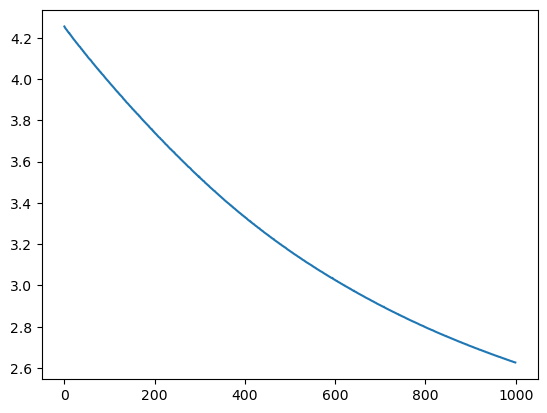

In [5]:
plt.plot(history.history['loss'])

Tensor("model/ExpandDims:0", shape=(None, 1), dtype=float32)
21/21 [==============================] - 0s 577us/step
(660,) (660, 1)


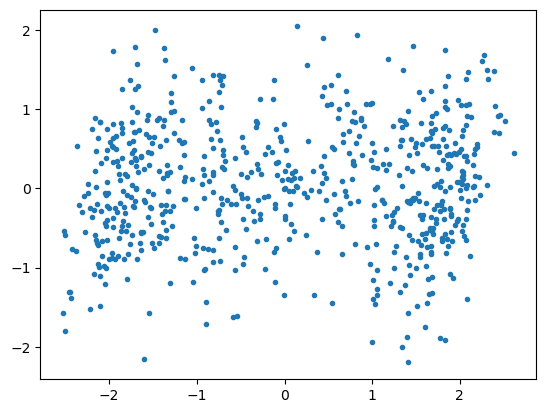

In [6]:
predictions = model.predict([X_test,t_test])
print(np.shape(y_test), np.shape(predictions))
plt.plot(y_test,predictions,'.')
plt.show()

In [7]:
# This is the final amp prediction!
sine_amp = np.asarray(model.layers[-1].get_weights())[0]
print(10.**sine_amp), 100*model.layers[-1].get_weights()[1], 10*10.**(10*model.layers[-1].get_weights()[2])
# Order is amp,offset, period


[[0.48807013]]


(None,
 array([[-1.466584]], dtype=float32),
 array([[50.842743]], dtype=float32))